In [1]:
# this notebook compares rescaling of zstack using static theories or a dynamic scaling factor theory.
# for the comparison we use microscopy data of beads stuck in agarose

#First load some packages
import psf_extra as psfe
import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
#load stacks
location = '../SF/bead_stack_data/20231020/' #location of stacks
gt_stack = psfe.load_stack(location+'water_stack_crop_xy_cs_206.tif')
distorted_stack = psfe.load_stack(location+'oil_stack_crop_xy_cs_208.tif')

shape_gt = np.shape(gt_stack)
shape_distorted = np.shape(distorted_stack)

# The coverslip should be at the last z-slice 
# To check: 
#plt.imshow(gt_stack[-1])
#plt.show()

#Then, if necessary: invert z direction
#gt_stack = gt_stack[::-1, :, :]
#distorted_stack = distorted_stack[::-1, :, :]

if len(shape_gt) > 3:
    gt_stack = gt_stack[:,:,:,0]
    shape_gt = np.shape(gt_stack)
if len(shape_distorted) > 3:
    distorted_stack = distorted_stack[:,:,:,0]
    shape_distorted = np.shape(distorted_stack)

print('Done!')

Done!


In [3]:
#define some parameters
medium_gt = 'water'
ps_xy_gt = 0.1553701 # um
ps_z_gt = 0.5 # um

medium_distorted = 'oil'
ps_xy_distorted = 0.1242961 # um
ps_z_distorted = 0.5 # um

n_im = 1.518
n_sample = 1.3358 # 2w% agarose in water - https://www.nature.com/articles/s41598-020-64103-3
lam_0 = 0.52 # microns
NA = 1.4

In [4]:
#compensate for loss of intensity in mismatched stack
distorted_stack_comp,_,_ = compensate_int_loss(distorted_stack,kernel_size=25,fit=False,skip_slides=20, plot=False)

#normalize to match histogram of gt stack:
factor = .3 # used to optimize histogram matching (see next cell)
distorted_stack_comp=distorted_stack_comp/(np.max(distorted_stack_comp)*factor)

#saturated values higher than 1 (for easier plotting):
distorted_stack_comp[distorted_stack_comp>1.0]=1.0

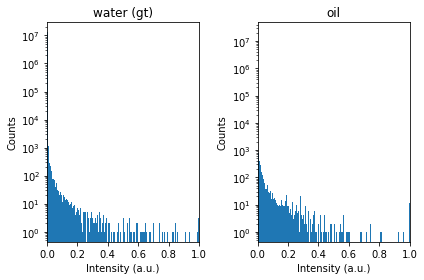

In [5]:
#check histograms (a bit slow for large stacks...):
plot_int_histograms(gt_stack,distorted_stack_comp,[medium_gt+' (gt)',medium_distorted])

After intensity loss compensation:


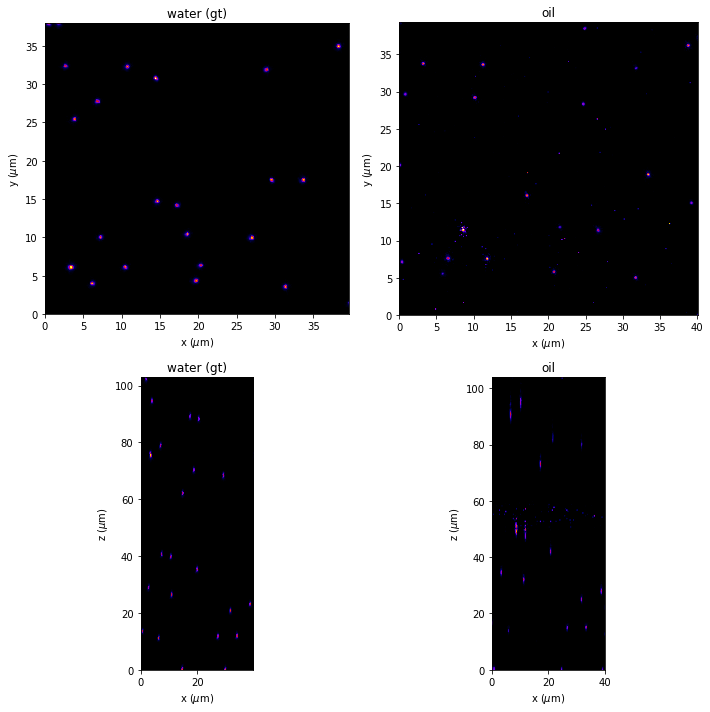

Before intensity loss compensation:


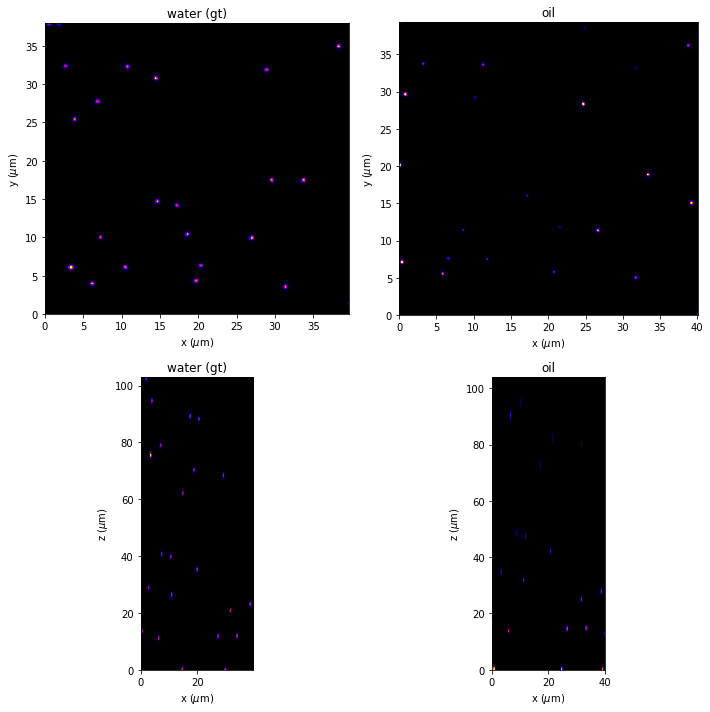

In [6]:
# plot MIPs of stacks
print("After intensity loss compensation:")
plot_stacks_MIPs(gt_stack,distorted_stack_comp,[medium_gt + ' (gt)',medium_distorted], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)
print("Before intensity loss compensation:")
plot_stacks_MIPs(gt_stack,distorted_stack,[medium_gt + ' (gt)',medium_distorted], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)

In [7]:
#rescale using depth-dependent rescaling
stack_rescaled, afp_new_stack, afp_stack, nfp_stack = rescale_stack(distorted_stack_comp[::-1], NA, n_im, n_sample, lam_0, ps_z_gt,crit='Lyakin')
#plot_stacks_overlay(stack_rescaled,distorted_stack_comp, afp_new_stack,afp_stack,nfp_stack,ps_xy_distorted,ps_z_gt)

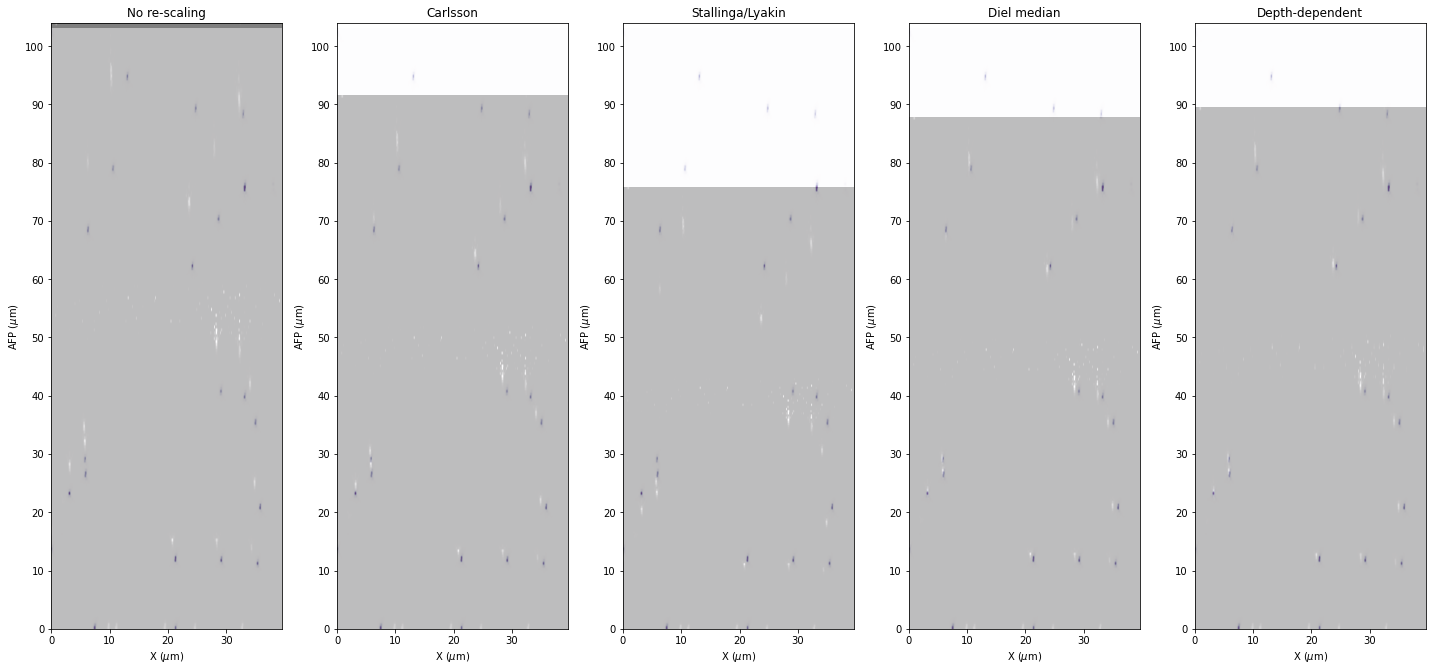

In [17]:
ps_z_distorted_diel_median = ps_z_distorted * diel_median([1],n_im,n_sample,NA)[0]
if n_sample > NA: ps_z_distorted_diel_mean = ps_z_distorted * diel_mean([1],n_im,n_sample,NA)[0]
ps_z_distorted_lyakin = ps_z_distorted * Lyakin([1],n_sample,n_im,NA)[0]
ps_z_distorted_stallinga = ps_z_distorted * stallinga_high([1],n_im,n_sample,[NA])[0]

#theories = ['no scaling','diel median', 'diel mean','lyakin','stallinga','depth-dependent']
#rescaled_ps_z = [ps_z_distorted, ps_z_distorted_diel_median,ps_z_distorted_diel_mean,ps_z_distorted_lyakin,ps_z_distorted_stallinga,ps_z_gt]

def plot_overlay_panels(theories, stack, stack_rescaled,gt_stack, ps_xy, ps_z, ps_xy_gt, ps_z_gt,rescaled_ps_z ): 
    colormaps = ['gray','Purples']
    fig,axs = plt.subplots(1,len(theories))
    fig.patch.set_facecolor('white')
    fig.set_figheight(20)
    fig.set_figwidth(20)
    shape = np.shape(stack)
    shape_rescaled = np.shape(stack_rescaled)
    shape_gt = np.shape(gt_stack)
    for i in range(len(theories)):
        theory = theories[i]
        axs[i].set_title(theories[i])
        #plot rescaled stack
        if i != len(theories)-1: # linear theory
            extent = [0, shape[2]*ps_xy_distorted, 0, shape[0]*rescaled_ps_z[i]]
            axs[i].imshow(np.max(stack, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5)
        else: # depth-dependent!
            extent = [0, shape[2]*ps_xy_distorted, 0, shape_rescaled[0]*ps_z_gt] # ps_z -> rescaled stack has been projected on pixel size of gt stack
            axs[i].imshow(np.max(np.flip(stack_rescaled,axis=0), axis=2),cmap=colormaps[0],extent=extent,alpha=0.5)
        
        # plot GT stack on each panel
        extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
        axs[i].imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5)
        axs[i].set_xlim(0, shape_gt[2]*ps_xy_gt)
      #  axs[i].set_xlim(110, 115)
        axs[i].set_ylim(0, shape[0]*ps_z)
        #axs[i].set_ylim(0, 150)
        axs[i].set_yticks(np.arange(0,101,10))
        axs[i].set_xlabel(r'X ($\mu$m)')
        axs[i].set_ylabel(r'AFP ($\mu$m)')
    plt.tight_layout()
    plt.show()
    return

theories = ['No re-scaling',
            'Carlsson',
            'Stallinga/Lyakin',
            'Diel median', 
            #'Diel mean', 
            'Depth-dependent']
rescaled_ps_z = [ps_z_distorted, 
                 ps_z_distorted*n_sample/n_im,
                 ps_z_distorted_lyakin,
                 ps_z_distorted_diel_median,
                 #ps_z_distorted_diel_mean,
                 ps_z_gt]

plot_overlay_panels(theories, distorted_stack_comp,stack_rescaled,gt_stack,ps_xy_distorted,ps_z_distorted,ps_xy_gt,ps_z_gt,rescaled_ps_z)

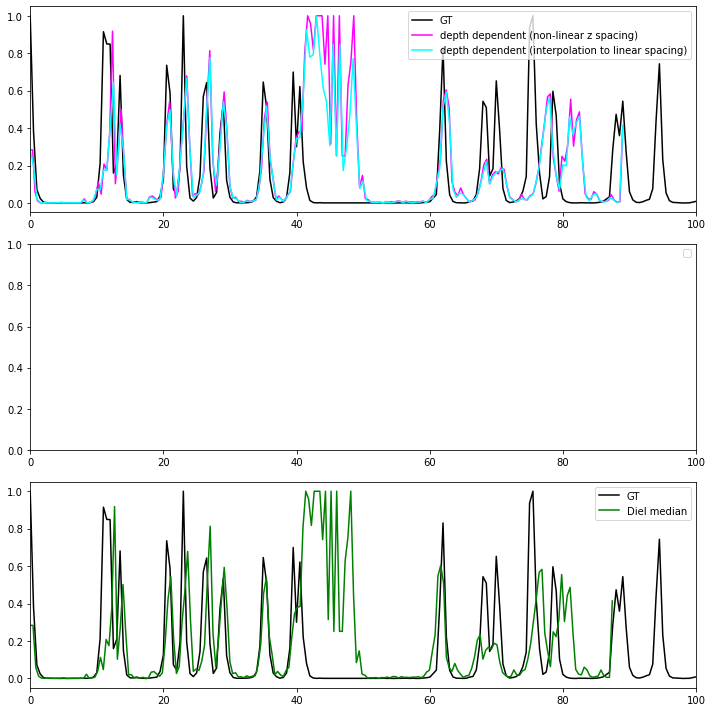

In [20]:
# project max intensity to line along z:

#gt stack
gt_stack_z_proj=np.max(gt_stack, axis=(1,2))
gt_stack_afp = np.arange(0,len(gt_stack_z_proj)*ps_z_gt,ps_z_gt) #generate depth list

# depth-dependent rescaled stack:
stack_rescaled_z_proj=np.max(stack_rescaled, axis=(1,2))

# diel mean rescaled:
stack_z_proj = np.max(distorted_stack_comp,axis=(1,2))
#stack_diel_mean_afp = np.arange(0,len(stack_z_proj)*ps_z_distorted_diel_mean,ps_z_distorted_diel_mean) #generate depth list

# diel median rescaled:
stack_diel_median_afp = np.arange(0,len(stack_z_proj)*ps_z_distorted_diel_median,ps_z_distorted_diel_median) #generate depth list

# mismatched stack:
stack_z_proj=np.max(distorted_stack_comp, axis=(1,2))

fig,axs=plt.subplots(3,1)
fig.patch.set_facecolor('white')

axs[0].plot(gt_stack_afp, np.flip(gt_stack_z_proj),label = 'GT',c='black')
axs[0].plot(afp_stack,np.flip(stack_z_proj)[:len(afp_stack)],label = 'depth dependent (non-linear z spacing)',c='magenta')
axs[0].plot(afp_new_stack,stack_rescaled_z_proj,label = 'depth dependent (interpolation to linear spacing)',c='cyan')
#axs[0].plot(nfp_stack,np.flip(stack_z_proj),label = 'no rescaling',c='green')

#axs[1].plot(gt_stack_afp, np.flip(gt_stack_z_proj),label = 'GT',c='black')
#axs[1].plot(stack_diel_mean_afp, np.flip(stack_z_proj),label = 'Diel mean',c='blue')

axs[2].plot(gt_stack_afp, np.flip(gt_stack_z_proj),label = 'GT',c='black')
axs[2].plot(stack_diel_median_afp, np.flip(stack_z_proj),label = 'Diel median',c='green')
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[0].set_xlim(0,100)
axs[1].set_xlim(0,100)
axs[2].set_xlim(0,100)
#axs[0].set_ylim(0,100)
#axs[1].set_ylim(0,0.5)
#axs[2].set_ylim(0,0.25)

plt.tight_layout()
plt.show()